# Top-k before vs after softmax

In the original FlexGen implementation of sparse-V attention, `top-k` is applied *after* the softmax (https://github.com/FMInference/FlexGen/blob/d34f7b4b43ed87a374f394b0535ed685af66197b/flexgen/pytorch_backend.py#L493-L495) and this is also how we implemented the sparse-V softmax.

However, `top-k` can also be applied *before* the softmax, such that the softmax weights of the selected values **sum to one**. Results here compare the two implementations.

Results are based on the subset of `TriviaQA` containing context documents with the number of characters between 4000 and 8000, and takes a sample of 400 examples.

In [76]:
%load_ext autoreload
%autoreload 2

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
df_b = pd.read_json("results/triviaqa_baseline.jsonl", lines=True)

In [79]:
df_b

,model,acc,open_book,_duration
0,pythia-70m,0.0275,True,231.905719
1,pythia-70m,0.0075,False,25.630940
2,pythia-160m,0.0700,True,652.207605
3,pythia-160m,0.0225,False,52.851532
4,pythia-410m,0.3275,True,1712.921767
5,pythia-410m,0.0625,False,133.788846
6,pythia-1b,0.4200,True,1950.175584
7,pythia-1b,0.1000,False,196.461193
8,pythia-1.4b,0.4925,True,3129.148747
9,pythia-1.4b,0.1725,False,276.111910


In [80]:
df = pd.read_json("results/triviaqa_topk_before.jsonl", lines=True)

In [81]:
# Filter out smaller models
df = df[df["model"].isin(["pythia-410m", "pythia-1b", "pythia-1.4b", "pythia-2.8b"])]

In [82]:
grouped = df.groupby("model", sort=False)

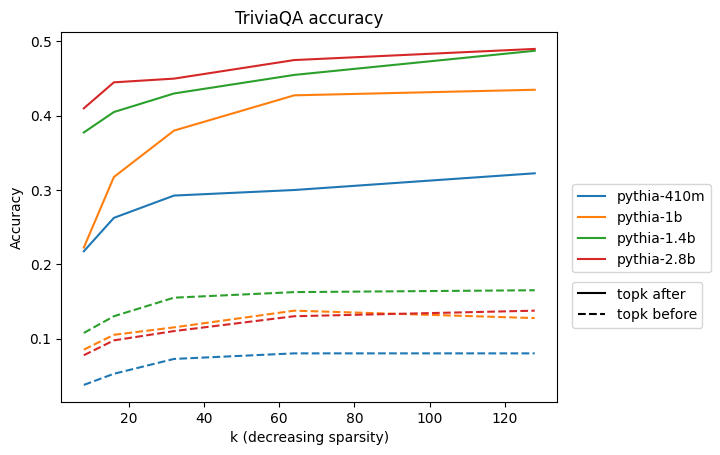

In [83]:
linestyles = ["-", "--"]
ax = plt.subplot()
model_names = []
for i, (model, group) in enumerate(grouped):
    model_names.append(model)
    col = f"C{i}"
    topk_group = group.groupby("topk_before")
    for topk_before, g in topk_group:
        ax.plot(g["k"], g["acc"], linestyle=linestyles[topk_before], color=col)
model_lines = [line for line in ax.get_lines() if line.get_linestyle() == "-"]

# Dummy plot for linestyle legend
dummy_lines = []
for linestyle in linestyles:
    dummy_lines.append(ax.plot([],[], c="black", linestyle=linestyle)[0])

legend1 = ax.legend(dummy_lines, ["topk after", "topk before"], loc=(1.03, 0.2))
legend2 = ax.legend(model_lines, model_names, loc=(1.03, 0.35))
ax.add_artist(legend1)
plt.title("TriviaQA accuracy")
plt.xlabel("k (decreasing sparsity)")
plt.ylabel("Accuracy")
plt.show()

The results indicate that applying `top-k` before the `softmax` significantly hinders the performance.